In [1]:
# import packages
import xarray as xr
import pandas as pd
import rasterio as rio
import geopandas as gpd
import rasterstats as rstats
import matplotlib.pyplot as plt
from rasterstats import zonal_stats, point_query
import numpy as np
import geoplot
import mapclassify
import statistics
import statsmodels.stats.api as sms
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn import datasets, metrics, model_selection, svm, linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb

from sklearn.inspection import permutation_importance
from matplotlib import pyplot
from sklearn.metrics import recall_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Import Keras and Tensorflow
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/graceliu/.conda/envs/waterproj/lib

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

In [4]:
# load and read gdb file with geopandas
ejscreen_gdb = r'EJSCREEN_2020_StatePctile.gdb'
ejscreen_gdf = gpd.read_file(ejscreen_gdb, engine = 'python')


In [5]:
# add column for classification as a low-income community
ejscreen_gdf['target'] = ejscreen_gdf['LOWINCPCT'] > 0.5

In [6]:
ejscreen_gdf.head()

,ID,STATE_NAME,ST_ABBREV,REGION,ACSTOTPOP,D_PM25_2,B_PM25_D2,P_PM25_D2,D_OZONE_2,B_OZONE_D2,P_OZONE_D2,D_DSLPM_2,B_DSLPM_D2,P_DSLPM_D2,D_CANCR_2,B_CANCR_D2,P_CANCR_D2,D_RESP_2,B_RESP_D2,P_RESP_D2,D_PTRAF_2,B_PTRAF_D2,P_PTRAF_D2,D_LDPNT_2,B_LDPNT_D2,P_LDPNT_D2,D_PNPL_2,B_PNPL_D2,P_PNPL_D2,D_PRMP_2,B_PRMP_D2,P_PRMP_D2,D_PTSDF_2,B_PTSDF_D2,P_PTSDF_D2,D_PWDIS_2,B_PWDIS_D2,P_PWDIS_D2,PM25,B_PM25,P_PM25,OZONE,B_OZONE,P_OZONE,DSLPM,B_DSLPM,P_DSLPM,CANCER,B_CANCR,P_CANCR,RESP,B_RESP,P_RESP,PTRAF,B_PTRAF,P_PTRAF,PRE1960PCT,B_LDPNT,P_LDPNT,PNPL,B_PNPL,P_PNPL,PRMP,B_PRMP,P_PRMP,PTSDF,B_PTSDF,P_PTSDF,PWDIS,B_PWDIS,P_PWDIS,VULEOPCT,B_VULEOPCT,P_VULEOPCT,MINORPCT,B_MINORPCT,P_MINORPCT,LOWINCPCT,B_LWINCPCT,P_LWINCPCT,LINGISOPCT,B_LNGISPCT,P_LNGISPCT,LESSHSPCT,B_LESHSPCT,P_LESHSPCT,UNDER5PCT,B_UNDR5PCT,P_UNDR5PCT,OVER64PCT,B_OVR64PCT,P_OVR64PCT,T_MINORPCT,T_LWINCPCT,T_LNGISPCT,T_LESHSPCT,T_UNDR5PCT,T_OVR64PCT,T_VULEOPCT,T_PM25,T_PM25_D2,T_OZONE,T_OZONE_D2,T_DSLPM,T_DSLPM_D2,T_CANCR,T_CANCR_D2,T_RESP,T_RESP_D2,T_PTRAF,T_PTRAF_D2,T_LDPNT,T_LDPNT_D2,T_PNPL,T_PNPL_D2,T_PRMP,T_PRMP_D2,T_PTSDF,T_PTSDF_D2,T_PWDIS,T_PWDIS_D2,Shape_Length,Shape_Area,geometry,target
0,010010201001,Alabama,AL,4,636,-492.025529,6,52.0,-1866.386370,6,52.0,-14.148258,6,51.0,-2506.966483,6,51.0,-40.010896,6,51.0,-4621.051601,4,35.0,-13.815487,4,31.0,-3.601838,5,40.0,-4.325802,6,53.0,-29.790608,4,38.0,NaN,0,NaN,9.690899,7,69.0,36.760212,3,24.0,0.278663,5,47.0,49.377032,9,84.0,0.788052,9,89.0,91.015900,6,55.0,0.272109,8,79.0,0.070942,8,79.0,0.085201,3,23.0,0.586754,6,57.0,NaN,0,NaN,0.274371,5,43.0,0.163522,4,35.0,0.385220,6,52.0,0.047619,10,92.0,0.208134,8,75.0,0.031447,3,23.0,0.150943,5,46.0,16% (35%ile),39% (52%ile),5% (92%ile),21% (75%ile),3% (23%ile),15% (46%ile),27% (43%ile),9.69 ug/m3 (69%ile),52%ile,36.8 ppb (24%ile),52%ile,0.279 ug/m3 (47%ile),51%ile,49 lifetime risk per million (84%ile),51%ile,0.79 (89%ile),51%ile,91 daily vehicles/meters distance (55%ile),35%ile,0.27 = fraction pre-1960 (79%ile),31%ile,0.071 facilities/km distance (79%ile),40%ile,0.085 facilities/km distance (23%ile),53%ile,0.59 facilities/km distance (57%ile),38%ile,None,None,13443.155206,6.040790e+06,"MULTIPOLYGON (((-9630291.644 3825463.001, -963...",False
1,010010201002,Alabama,AL,4,1287,-2053.083414,4,30.0,-7787.902602,4,32.0,-59.036679,4,30.0,-10460.862287,3,27.0,-166.954157,3,26.0,-554.798777,5,46.0,-24.461822,3,20.0,-13.631646,2,19.0,-15.634259,5,42.0,-95.462908,3,23.0,NaN,0,NaN,9.690899,7,69.0,36.760212,3,24.0,0.278663,5,47.0,49.377032,9,84.0,0.788052,9,89.0,2.618744,2,14.0,0.115464,6,50.0,0.064344,8,76.0,0.073796,2,17.0,0.450601,6,52.0,NaN,0,NaN,0.189588,3,22.0,0.216006,5,44.0,0.163170,2,15.0,0.000000,8,71.0,0.040678,2,15.0,0.041958,4,34.0,0.115773,3,28.0,22% (44%ile),16% (15%ile),0% (71%ile),4% (15%ile),4% (34%ile),12% (28%ile),19% (22%ile),9.69 ug/m3 (69%ile),30%ile,36.8 ppb (24%ile),32%ile,0.279 ug/m3 (47%ile),30%ile,49 lifetime risk per million (84%ile),27%ile,0.79 (89%ile),26%ile,2.6 daily vehicles/meters distance (14%ile),46%ile,0.12 = fraction pre-1960 (50%ile),20%ile,0.064 facilities/km distance (76%ile),19%ile,0.074 facilities/km distance (17%ile),42%ile,0.45 facilities/km distance (52%ile),23%ile,None,None,11917.089598,7.834160e+06,"MULTIPOLYGON (((-9629649.776 3826119.733, -962...",False
2,010010202001,Alabama,AL,4,810,1846.126938,8,75.0,7002.783717,8,75.0,57.850440,8,76.0,9566.077321,8,77.0,153.743920,8,78.0,889.548734,7,64.0,27.230838,8,77.0,13.161449,9,85.0,14.802837,7,67.0,124.208381,8,77.0,NaN,0,NaN,9.711240,8,70.0,36.836966,3,25.0,0.304313,6,54.0,50.320741,9,89.0,0.808744,10,93.0,4.679322,2,17.0,0.143243,6,57.0,0.069234,8,78.0,0.077868,3,20.0,0.653377,6,59.0,NaN,0,NaN,0.588895,9,82.0,0.676543,9,83.0,0.501247,8,73.0,0.000000,8,71.0,0.135563,6,53.0,0.041975,4,34.0,0.224691,9,83.0,68% (83%ile),50% (73%ile),0% (71%ile),14% (53%ile),4% (34%ile),22% (83%ile),59% (82%ile),9.71 ug/m3 (70%ile),75%ile,36.8 ppb (25%ile),75%ile,0.304 ug/m3 (54%ile),76%ile,50 lifetime risk per million 

## Map a few variables for EDA

<AxesSubplot:>

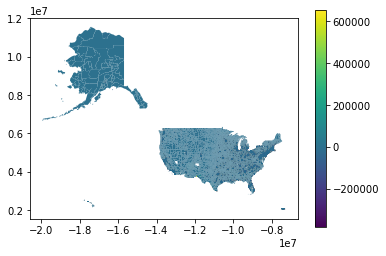

In [6]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
ejscreen_gdf.plot(column = "D_CANCR_2", ax = ax, legend = True)
#fig.savefig('cancer.png')

<AxesSubplot:>

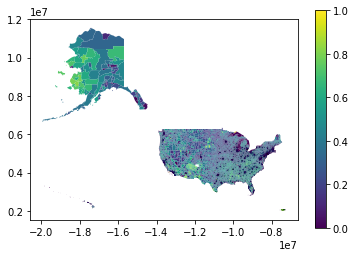

In [7]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
ejscreen_gdf.plot(column = "LOWINCPCT", ax = ax, legend = True)
#fig.savefig('cancer.png')

In [51]:
ejscreen_gdf.STATE_NAME.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
      dtype=object)

<AxesSubplot:>

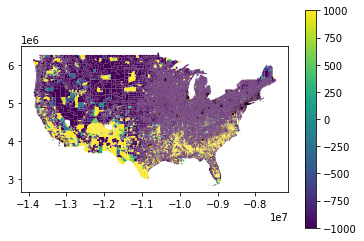

In [18]:
us = ejscreen_gdf[(ejscreen_gdf['STATE_NAME'] != "Alaska") & (ejscreen_gdf['STATE_NAME'] != "Hawaii") & (ejscreen_gdf['STATE_NAME'] != "Puerto Rico")]

# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
us.plot(column = "D_CANCR_2", ax = ax, legend = True, vmin=-1000, vmax=1000)
#fig.savefig('cancer.png')

<AxesSubplot:>

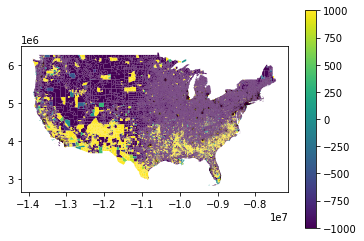

In [11]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
us.plot(column = "D_OZONE_2", ax = ax, legend = True, vmin=-1000, vmax=1000)
#fig.savefig('cancer.png')

<AxesSubplot:>

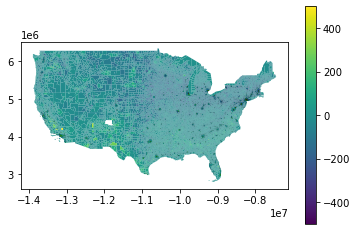

In [19]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
us.plot(column = "D_LDPNT_2", ax = ax, legend = True, vmin=-500, vmax=500)
#fig.savefig('cancer.png')

<AxesSubplot:>

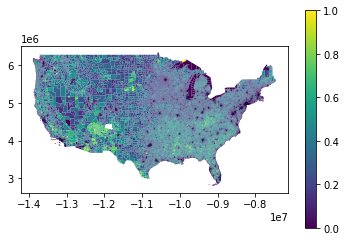

In [57]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
us.plot(column = "LOWINCPCT", ax = ax, legend = True)
#fig.savefig('cancer.png')

<AxesSubplot:>

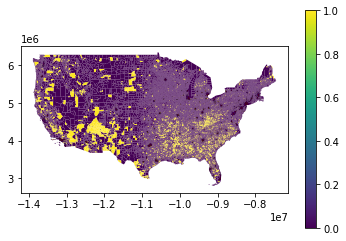

In [58]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
us.plot(column = "target", ax = ax, legend = True)
#fig.savefig('cancer.png')

<AxesSubplot:>

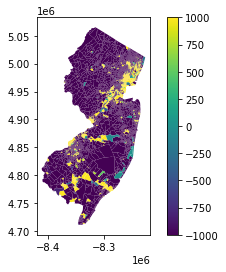

In [13]:
nj = ejscreen_gdf[ejscreen_gdf['STATE_NAME'] == "New Jersey"]

# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
nj.plot(column = "D_CANCR_2", ax = ax, legend = True, vmin=-1000, vmax=1000)
#fig.savefig('cancer.png')

<AxesSubplot:>

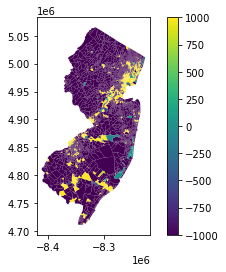

In [14]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
nj.plot(column = "D_OZONE_2", ax = ax, legend = True, vmin=-1000, vmax=1000)
#fig.savefig('cancer.png')

<AxesSubplot:>

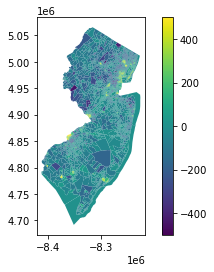

In [16]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
nj.plot(column = "D_LDPNT_2", ax = ax, legend = True, vmin=-500, vmax=500)
#fig.savefig('cancer.png')

<AxesSubplot:>

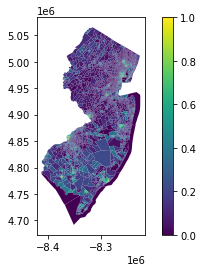

In [15]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
nj.plot(column = "LOWINCPCT", ax = ax, legend = True)
#fig.savefig('cancer.png')

<AxesSubplot:>

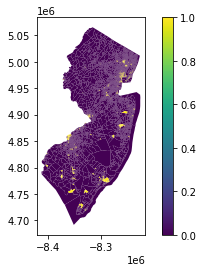

In [16]:
# Plot the data for a feature
fig, ax = plt.subplots(1, 1)
nj.plot(column = "target", ax = ax, legend = True)
#fig.savefig('cancer.png')

## Select features related to pollutant levels

In [14]:
ejscreen_df = pd.DataFrame(ejscreen_gdf[['D_LDPNT_2', 'D_DSLPM_2', 'D_CANCR_2', 'D_RESP_2', 'D_PTRAF_2', 'D_PWDIS_2', 'D_PNPL_2', 'D_PRMP_2', 'D_PTSDF_2', 'D_OZONE_2', 'D_PM25_2', 'target']])

In [15]:
ejscreen_df.head()

,D_LDPNT_2,D_DSLPM_2,D_CANCR_2,D_RESP_2,D_PTRAF_2,D_PWDIS_2,D_PNPL_2,D_PRMP_2,D_PTSDF_2,D_OZONE_2,D_PM25_2,target
0,-13.815487,-14.148258,-2506.966483,-40.010896,-4621.051601,NaN,-3.601838,-4.325802,-29.790608,-1866.386370,-492.025529,False
1,-24.461822,-59.036679,-10460.862287,-166.954157,-554.798777,NaN,-13.631646,-15.634259,-95.462908,-7787.902602,-2053.083414,False
2,27.230838,57.850440,9566.077321,153.743920,889.548734,NaN,13.161449,14.802837,124.208381,7002.783717,1846.126938,True
3,49.071003,43.622227,7213.317639,115.930876,31342.420074,NaN,10.839023,12.459380,144.693543,5280.461532,1392.075305,False
4,-6.622665,-28.752998,-4008.215270,-64.480301,-5498.078216,NaN,-5.835112,-6.337256,-92.978762,-2911.892606,-769.374640,False


In [16]:
# Merge data and split into training and testing
ejscreen_train, ejscreen_test = train_test_split(ejscreen_df, test_size=0.2, random_state=42)

# impute missing values
imputer = IterativeImputer(random_state=0)
ejscreen_train = imputer.fit_transform(ejscreen_train)
ejscreen_train = pd.DataFrame(ejscreen_train)
ejscreen_train.columns = ['D_LDPNT_2', 'D_DSLPM_2', 'D_CANCR_2', 'D_RESP_2', 'D_PTRAF_2', 'D_PWDIS_2', 'D_PNPL_2', 'D_PRMP_2', 'D_PTSDF_2', 'D_OZONE_2', 'D_PM25_2', 'target']
ejscreen_test = ejscreen_test.dropna()

ejscreen_train_features = ejscreen_train.drop('target', axis = 1)
ejscreen_train_target = ejscreen_train['target']

ejscreen_test_features = ejscreen_test.drop('target', axis = 1)
ejscreen_test_target = ejscreen_test['target']

## More EDA with pairplots

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


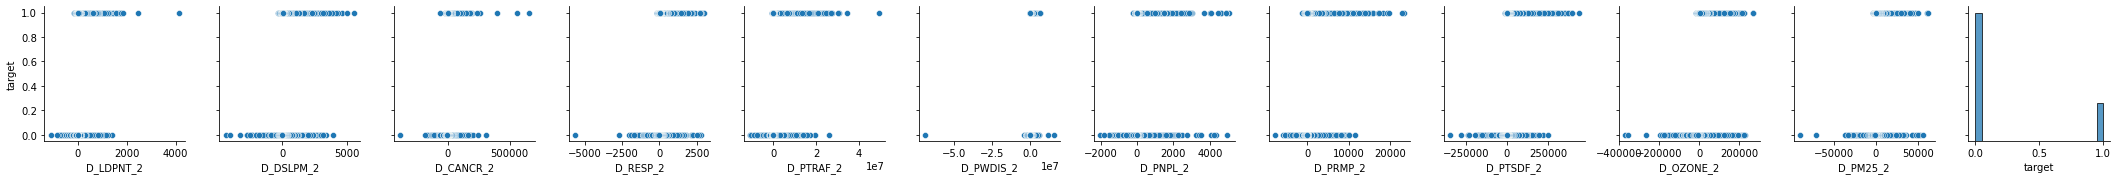

In [81]:
g = sns.pairplot(ejscreen_df, x_vars = ejscreen_df.columns, y_vars=["target"])

In [83]:
# Compute the correlation matrix
ejscreen_df.corr()

,D_LDPNT_2,D_DSLPM_2,D_CANCR_2,D_RESP_2,D_PTRAF_2,D_PWDIS_2,D_PNPL_2,D_PRMP_2,D_PTSDF_2,D_OZONE_2,D_PM25_2,target
D_LDPNT_2,1.000000,0.720254,0.661979,0.681429,0.463441,0.029877,0.447002,0.531959,0.385793,0.678442,0.682012,0.486018
D_DSLPM_2,0.720254,1.000000,0.827718,0.870394,0.556332,0.028024,0.495991,0.555384,0.593316,0.788171,0.806109,0.430768
D_CANCR_2,0.661979,0.827718,1.000000,0.966260,0.453550,0.025390,0.464949,0.606040,0.310029,0.938308,0.954910,0.501309
D_RESP_2,0.681429,0.870394,0.966260,1.000000,0.489332,0.026874,0.479026,0.621073,0.362377,0.947649,0.966262,0.504295
D_PTRAF_2,0.463441,0.556332,0.453550,0.489332,1.000000,0.019823,0.292566,0.356464,0.374323,0.431485,0.457996,0.246145
D_PWDIS_2,0.029877,0.028024,0.025390,0.026874,0.019823,1.000000,0.017790,0.046787,0.009481,0.026169,0.028932,0.013690
D_PNPL_2,0.447002,0.495991,0.464949,0.479026,0.292566,0.017790,1.000000,0.402935,0.261447,0.463542,0.477447,0.261755
D_PRMP_2,0.531959,0.555384,0.606040,0.621073,0.356464,0.046787,0.402935,1.000000,0.182698,0.591790,0.620144,0.358809
D_PTSDF_2,0.385793,0.593316,0.310029,0.362377,0.374323,0.009481,0.261447,0.182698,1.000000,0.264871,0.270668,0.145932
D_OZONE_2,0.678442,0.788171,0.938308,0.947649,0.431485,0.026169,0.463542,0.591790,0.264871,1.000000,0.977892,0.530836


In [82]:
# check the imbalance of the dataset
print("number of low-income commuities: " + str(ejscreen_df[ejscreen_df['target'] == 1].shape))
print("number of not low-income communities: " + str(ejscreen_df[ejscreen_df['target'] == 0].shape))

number of low-income commuities: (50474, 12)
number of not low-income communities: (169859, 12)


## Build binary classifiers for predicting low income communities 

### Naive Bayes

In [35]:
# Find the optimal hyperparameters for the classifier 
clf = GaussianNB()

# create grid 
param_grid = { 
    'var_smoothing': np.logspace(0,-9, num=100)
}

# apply grid to model
search = RandomizedSearchCV(clf, param_grid, cv=5, scoring = "recall").fit(ejscreen_train_features, ejscreen_train_target)

In [36]:
# Optimal hyperparameter 
print(search.best_params_)
clf = search.best_estimator_

{'var_smoothing': 8.111308307896856e-09}


              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88    135972
         1.0       0.61      0.51      0.55     40294

    accuracy                           0.81    176266
   macro avg       0.73      0.70      0.72    176266
weighted avg       0.80      0.81      0.81    176266



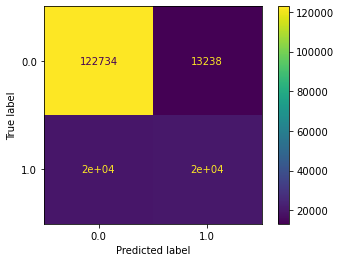

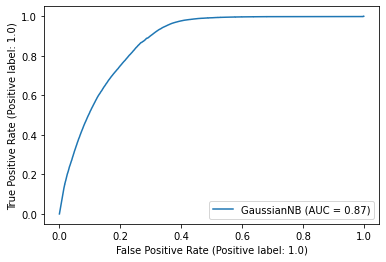

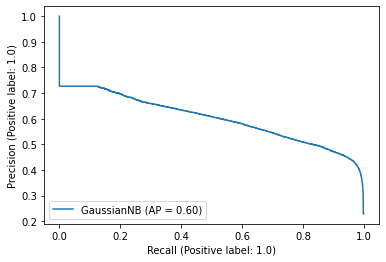

In [37]:
# Test the classifier on the training data
train_pred = clf.predict(ejscreen_train_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
train_pred = np.where(clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD, 1, 0)
train_pred = (clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our training data and plot an ROC curve
print(classification_report(ejscreen_train_target, train_pred))

cm = confusion_matrix(ejscreen_train_target, train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_train_features, ejscreen_train_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_train_features, ejscreen_train_target)
plt.show()

              precision    recall  f1-score   support

       False       0.86      0.90      0.88     21104
        True       0.63      0.52      0.57      6560

    accuracy                           0.81     27664
   macro avg       0.74      0.71      0.72     27664
weighted avg       0.80      0.81      0.81     27664



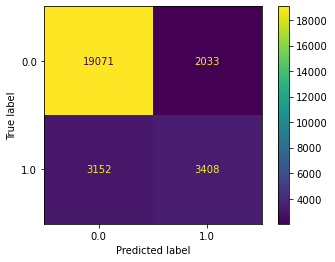

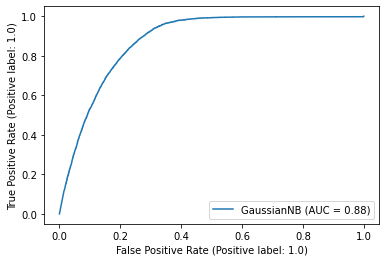

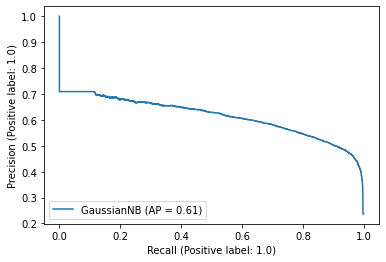

In [40]:
# Test the random forest classifier on the test data
test_pred = clf.predict(ejscreen_test_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
test_pred = np.where(clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD, 1, 0)
test_pred = (clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our test data and plot an ROC curve
print(classification_report(ejscreen_test_target, test_pred))

cm = confusion_matrix(ejscreen_test_target, test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_test_features, ejscreen_test_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_test_features, ejscreen_test_target)
plt.show()

### Logistic Regression

In [41]:
# Find the optimal hyperparameters for the classifier 
clf = LogisticRegression()

# create grid 
param_grid = { 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}

# apply grid to model
search = RandomizedSearchCV(clf, param_grid, cv=5, scoring = "recall").fit(ejscreen_train_features, ejscreen_train_target)

/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-pack

/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-p

/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/graceliu/.conda/envs/waterproj/lib/python3.7/site-pack

In [42]:
# Optimal hyperparameter for max_depth, max_leaf_nodes, class_weight, min_samples_split in Random Forest Classifier
print(search.best_params_)
clf = search.best_estimator_

{'solver': 'saga', 'penalty': 'l1', 'C': 0.01}


              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01    135972
         1.0       0.23      1.00      0.37     40294

    accuracy                           0.23    176266
   macro avg       0.61      0.50      0.19    176266
weighted avg       0.82      0.23      0.10    176266



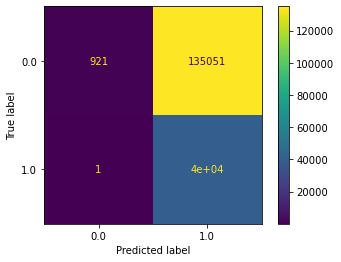

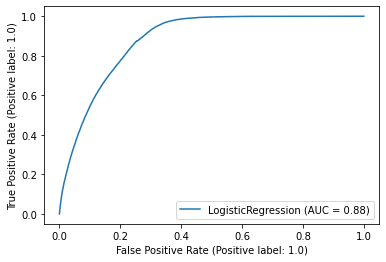

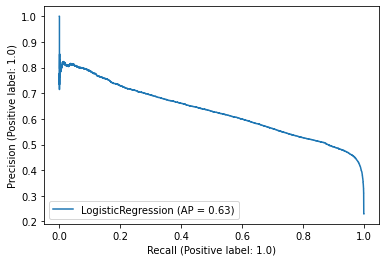

In [43]:
# Test the classifier on the training data
train_pred = clf.predict(ejscreen_train_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
train_pred = np.where(clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD, 1, 0)
train_pred = (clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our training data and plot an ROC curve
print(classification_report(ejscreen_train_target, train_pred))

cm = confusion_matrix(ejscreen_train_target, train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_train_features, ejscreen_train_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_train_features, ejscreen_train_target)
plt.show()

              precision    recall  f1-score   support

       False       1.00      0.02      0.04     21299
        True       0.24      1.00      0.38      6447

    accuracy                           0.25     27746
   macro avg       0.62      0.51      0.21     27746
weighted avg       0.82      0.25      0.12     27746



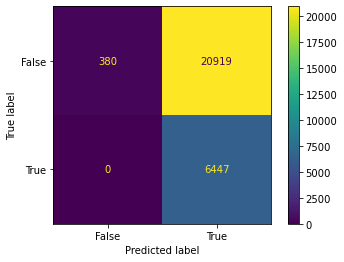

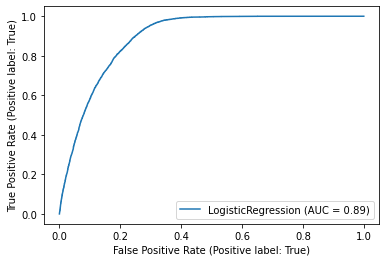

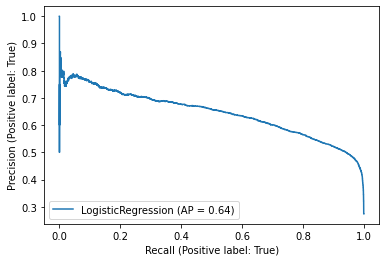

In [26]:
# Test the classifier on the test data
test_pred = clf.predict(ejscreen_test_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
test_pred = np.where(clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD, 1, 0)
test_pred = (clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our test data and plot an ROC curve
print(classification_report(ejscreen_test_target, test_pred))

cm = confusion_matrix(ejscreen_test_target, test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_test_features, ejscreen_test_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_test_features, ejscreen_test_target)
plt.show()

### Random Forest Classifier

In [50]:
# Find the optimal hyperparameters for the classifier 
clf = RandomForestClassifier()

# create grid 
param_grid = { 
    'max_depth': [5, 10, 15, None],
    'max_leaf_nodes': [5, 10, 30, None],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'min_samples_split': [2, 5, 10, 20]
}

# apply grid to model
search = RandomizedSearchCV(clf, param_grid, cv=5, scoring = "recall").fit(ejscreen_train_features, ejscreen_train_target)

In [51]:
# Optimal hyperparameter for max_depth, max_leaf_nodes, class_weight, min_samples_split in Random Forest Classifier
print(search.best_params_)
clf = search.best_estimator_

{'min_samples_split': 2, 'max_leaf_nodes': 10, 'max_depth': 15, 'class_weight': 'balanced_subsample'}


              precision    recall  f1-score   support

         0.0       0.99      0.64      0.78    135972
         1.0       0.45      0.98      0.61     40294

    accuracy                           0.72    176266
   macro avg       0.72      0.81      0.70    176266
weighted avg       0.87      0.72      0.74    176266



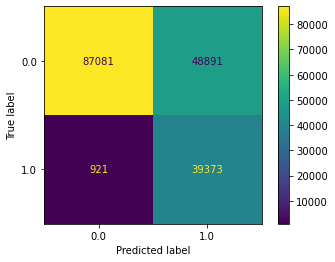

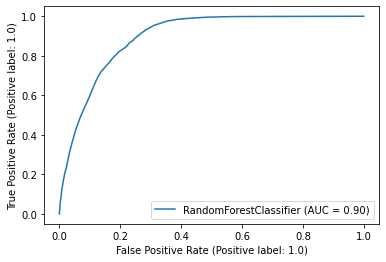

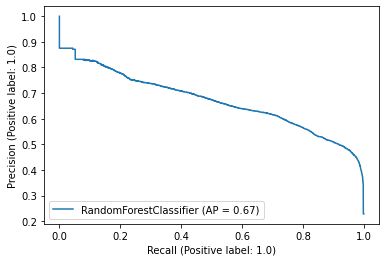

In [52]:
# Test the classifier on the training data
train_pred = clf.predict(ejscreen_train_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
train_pred = np.where(clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD, 1, 0)
train_pred = (clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our training data and plot an ROC curve
print(classification_report(ejscreen_train_target, train_pred))

cm = confusion_matrix(ejscreen_train_target, train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_train_features, ejscreen_train_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_train_features, ejscreen_train_target)
plt.show()

              precision    recall  f1-score   support

       False       0.99      0.66      0.79     21104
        True       0.48      0.98      0.64      6560

    accuracy                           0.74     27664
   macro avg       0.73      0.82      0.72     27664
weighted avg       0.87      0.74      0.76     27664



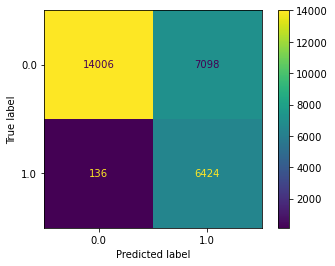

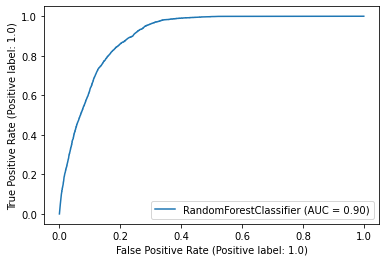

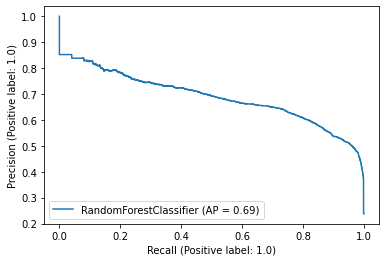

In [53]:
# Test the classifier on the test data
test_pred = clf.predict(ejscreen_test_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
test_pred = np.where(clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD, 1, 0)
test_pred = (clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our test data and plot an ROC curve
print(classification_report(ejscreen_test_target, test_pred))

cm = confusion_matrix(ejscreen_test_target, test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_test_features, ejscreen_test_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_test_features, ejscreen_test_target)
plt.show()

### Decision Tree

In [44]:
# Find the optimal hyperparameters for the classifier 
clf = DecisionTreeClassifier(random_state=42)

# create grid 
## grid values from: https://www.kaggle.com/gauravduttakiit/hyperparameter-tuning-in-decision-trees
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# apply grid to model
search = RandomizedSearchCV(clf, param_grid, cv=5, scoring = "recall").fit(ejscreen_train_features, ejscreen_train_target)

In [45]:
# Optimal hyperparameter 
print(search.best_params_)
clf = search.best_estimator_

{'min_samples_leaf': 10, 'max_depth': 2, 'criterion': 'entropy'}


              precision    recall  f1-score   support

         0.0       0.98      0.66      0.79    135972
         1.0       0.46      0.96      0.62     40294

    accuracy                           0.73    176266
   macro avg       0.72      0.81      0.70    176266
weighted avg       0.86      0.73      0.75    176266



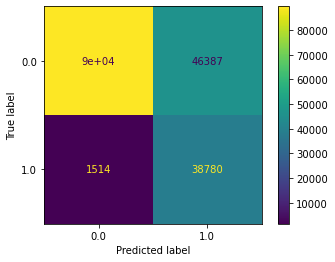

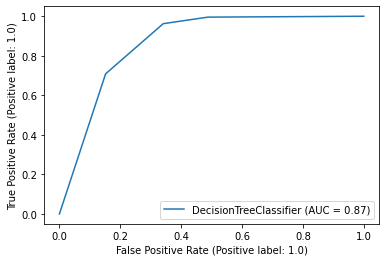

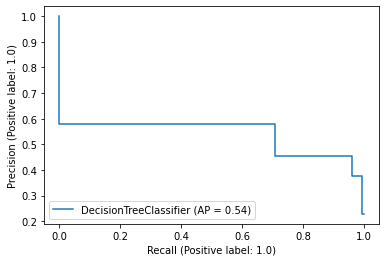

In [46]:
# Test the classifier on the training data
train_pred = clf.predict(ejscreen_train_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
train_pred = np.where(clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD, 1, 0)
train_pred = (clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our training data and plot an ROC curve
print(classification_report(ejscreen_train_target, train_pred))

cm = confusion_matrix(ejscreen_train_target, train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_train_features, ejscreen_train_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_train_features, ejscreen_train_target)
plt.show()

              precision    recall  f1-score   support

       False       0.98      0.68      0.80     21104
        True       0.48      0.96      0.64      6560

    accuracy                           0.75     27664
   macro avg       0.73      0.82      0.72     27664
weighted avg       0.87      0.75      0.77     27664



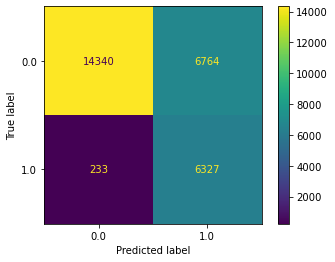

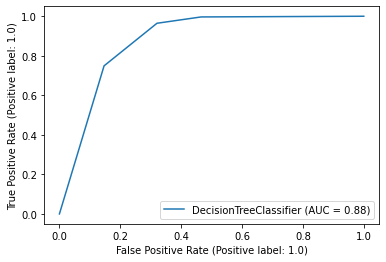

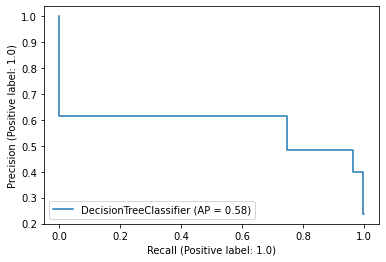

In [47]:
# Test the classifier on the test data
test_pred = clf.predict(ejscreen_test_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
test_pred = np.where(clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD, 1, 0)
test_pred = (clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our test data and plot an ROC curve
print(classification_report(ejscreen_test_target, test_pred))

cm = confusion_matrix(ejscreen_test_target, test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_test_features, ejscreen_test_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_test_features, ejscreen_test_target)
plt.show()

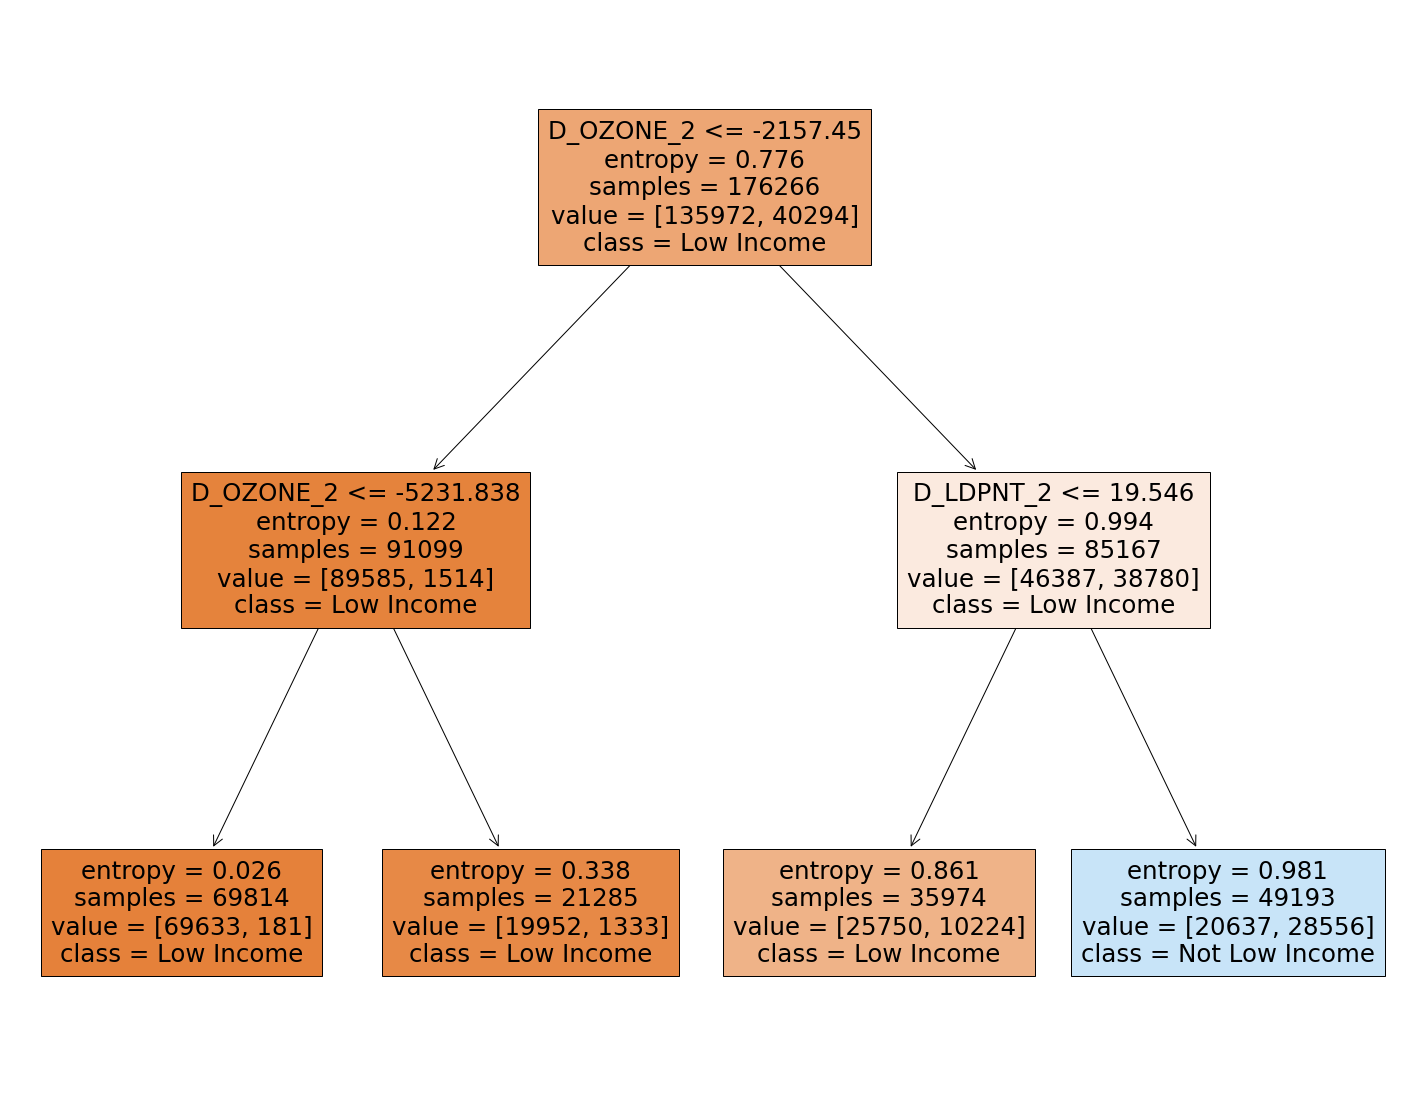

In [49]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, feature_names=ejscreen_train_features.columns, class_names=['Low Income', "Not Low Income"], filled=True)

### XGBoost Classifier

In [54]:
clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

#https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a
param_grid = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__k': [10],
  }
]
steps = 20  # The number of training iterations

search = RandomizedSearchCV(clf, param_grid, cv=5, scoring = "f1").fit(ejscreen_train_features, ejscreen_train_target)

[15:48:11] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:48:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:22] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[15:50:18] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:50:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:28] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[15:52:23] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:52:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:34] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[15:54:31] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:54:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:42] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[15:56:40] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:56:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:50] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

In [55]:
# Optimal hyperparameter 
print(search.best_params_)
clf = search.best_estimator_

{'fs__k': 10, 'clf__n_estimators': 50, 'clf__max_depth': 4, 'clf__learning_rate': 0.1, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.1}


              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88    135972
         1.0       0.59      0.93      0.72     40294

    accuracy                           0.84    176266
   macro avg       0.78      0.87      0.80    176266
weighted avg       0.89      0.84      0.85    176266



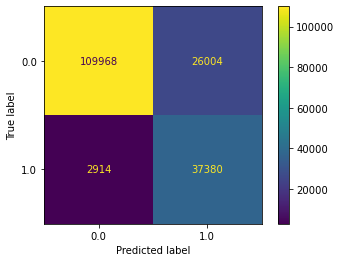

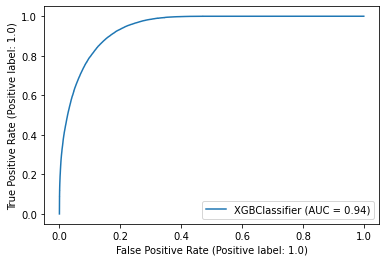

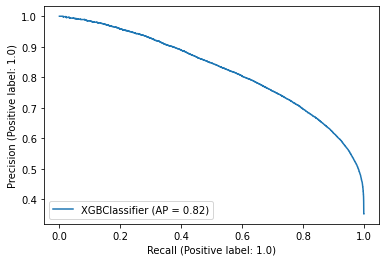

In [56]:
# Test the classifier on the training data
train_pred = clf.predict(ejscreen_train_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
train_pred = np.where(clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD, 1, 0)
train_pred = (clf.predict_proba(ejscreen_train_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our training data and plot an ROC curve
print(classification_report(ejscreen_train_target, train_pred))

cm = confusion_matrix(ejscreen_train_target, train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_train_features, ejscreen_train_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_train_features, ejscreen_train_target)
plt.show()

              precision    recall  f1-score   support

       False       0.97      0.79      0.87     21104
        True       0.57      0.92      0.70      6560

    accuracy                           0.82     27664
   macro avg       0.77      0.85      0.79     27664
weighted avg       0.87      0.82      0.83     27664



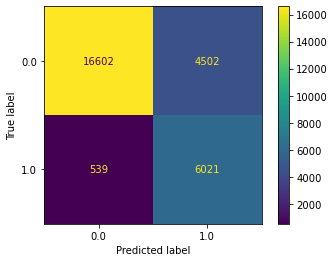

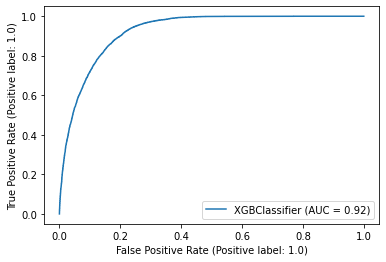

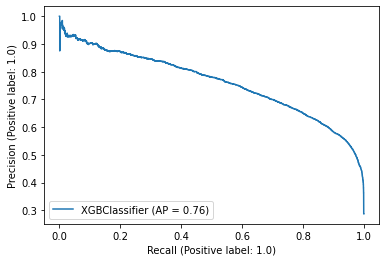

In [57]:
# Test the classifier on the test data
test_pred = clf.predict(ejscreen_test_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
test_pred = np.where(clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD, 1, 0)
test_pred = (clf.predict_proba(ejscreen_test_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our test data and plot an ROC curve
print(classification_report(ejscreen_test_target, test_pred))

cm = confusion_matrix(ejscreen_test_target, test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, ejscreen_test_features, ejscreen_test_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, ejscreen_test_features, ejscreen_test_target)
plt.show()

## Preprocess NJ data

In [7]:
nj_gdf = ejscreen_gdf[ejscreen_gdf['STATE_NAME'] == "New Jersey"]
nj_df = pd.DataFrame(nj_gdf[['D_LDPNT_2', 'D_DSLPM_2', 'D_CANCR_2', 'D_RESP_2', 'D_PTRAF_2', 'D_PWDIS_2', 'D_PNPL_2', 'D_PRMP_2', 'D_PTSDF_2', 'D_OZONE_2', 'D_PM25_2', 'target']])

In [8]:
# Merge data and split into training and testing
nj_train, nj_test = train_test_split(nj_df, test_size=0.2, random_state=42)

# impute missing values
imputer = IterativeImputer(random_state=0)
nj_train = imputer.fit_transform(nj_train)
nj_train = pd.DataFrame(nj_train)
nj_train.columns = ['D_LDPNT_2', 'D_DSLPM_2', 'D_CANCR_2', 'D_RESP_2', 'D_PTRAF_2', 'D_PWDIS_2', 'D_PNPL_2', 'D_PRMP_2', 'D_PTSDF_2', 'D_OZONE_2', 'D_PM25_2', 'target']
nj_test = nj_test.dropna()

nj_train_features = nj_train.drop('target', axis = 1)
nj_train_target = nj_train['target']

nj_test_features = nj_test.drop('target', axis = 1)
nj_test_target = nj_test['target']

## Decision Tree for NJ data

In [63]:
# Find the optimal hyperparameters for the classifier 
clf = DecisionTreeClassifier(random_state=42)

# create grid 
## grid values from: https://www.kaggle.com/gauravduttakiit/hyperparameter-tuning-in-decision-trees
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# apply grid to model
search = RandomizedSearchCV(clf, param_grid, cv=5, scoring = "recall").fit(nj_train_features, nj_train_target)

In [69]:
# Optimal hyperparameter 
print(search.best_params_)
clf = search.best_estimator_

{'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'gini'}


              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95      4426
         1.0       0.63      0.92      0.75       630

    accuracy                           0.92      5056
   macro avg       0.81      0.92      0.85      5056
weighted avg       0.94      0.92      0.93      5056



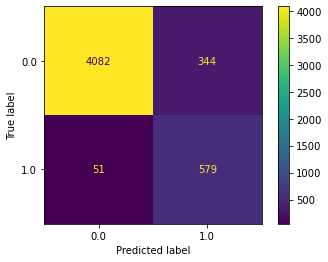

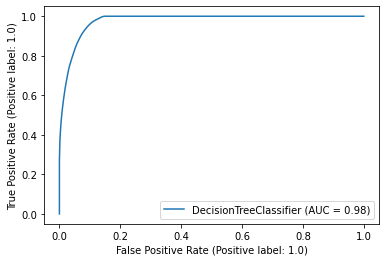

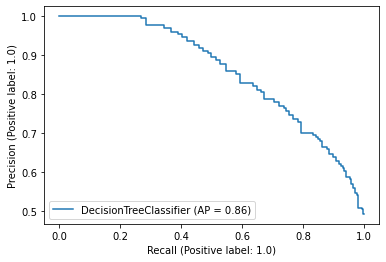

In [65]:
# Test the classifier on the training data
train_pred = clf.predict(nj_train_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
train_pred = np.where(clf.predict_proba(nj_train_features)[:,1] >= THRESHOLD, 1, 0)
train_pred = (clf.predict_proba(nj_train_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our training data and plot an ROC curve
print(classification_report(nj_train_target, train_pred))

cm = confusion_matrix(nj_train_target, train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, nj_train_features, nj_train_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, nj_train_features, nj_train_target)
plt.show()

              precision    recall  f1-score   support

       False       0.97      0.91      0.93       816
        True       0.47      0.72      0.57        93

    accuracy                           0.89       909
   macro avg       0.72      0.81      0.75       909
weighted avg       0.91      0.89      0.90       909



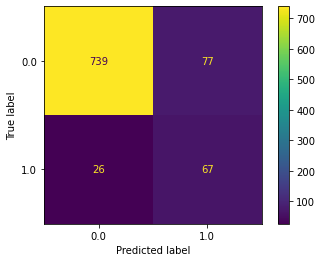

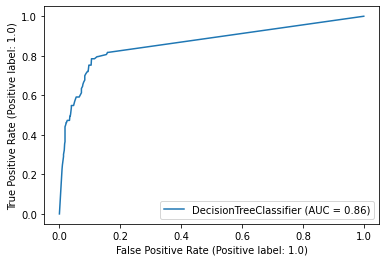

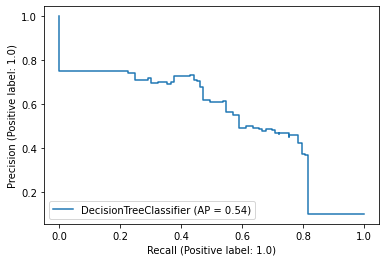

In [66]:
# Test the classifier on the test data
test_pred = clf.predict(nj_test_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
test_pred = np.where(clf.predict_proba(nj_test_features)[:,1] >= THRESHOLD, 1, 0)
test_pred = (clf.predict_proba(nj_test_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our test data and plot an ROC curve
print(classification_report(nj_test_target, test_pred))

cm = confusion_matrix(nj_test_target, test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, nj_test_features, nj_test_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, nj_test_features, nj_test_target)
plt.show()

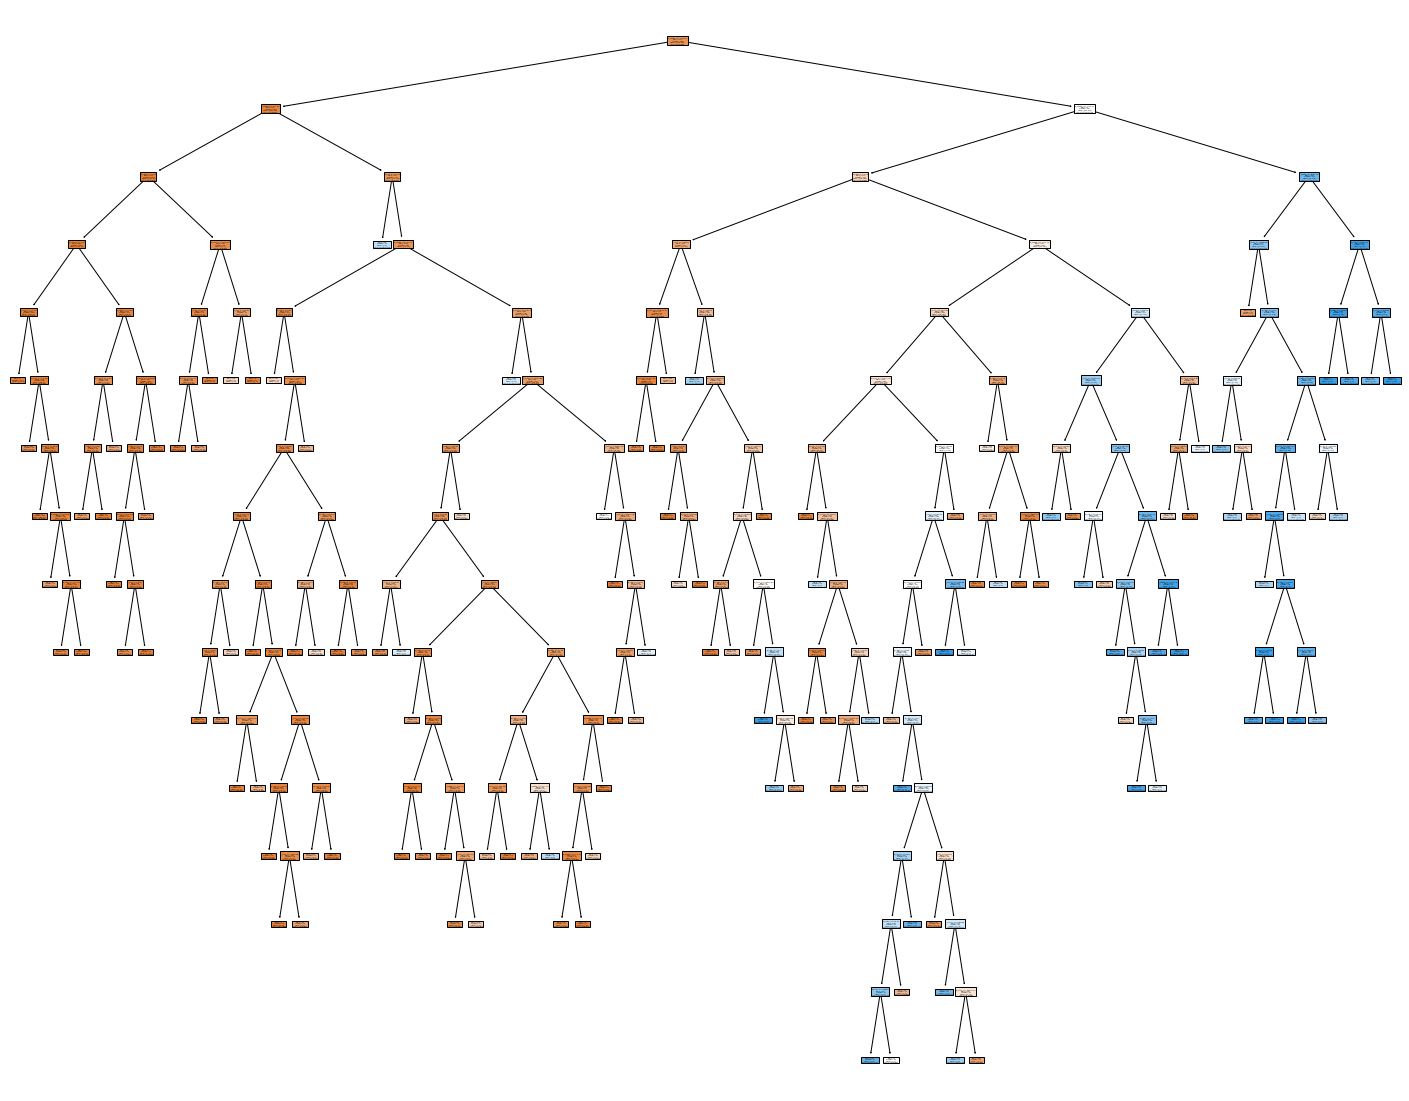

In [73]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, feature_names=nj_train_features.columns, class_names=['Low Income', "Not Low Income"], filled=True)

In [80]:
nj_train_features.head()

,D_LDPNT_2,D_DSLPM_2,D_CANCR_2,D_RESP_2,D_PTRAF_2,D_PWDIS_2,D_PNPL_2,D_PRMP_2,D_PTSDF_2,D_OZONE_2,D_PM25_2
0,-86.188067,-159.942154,-8930.543999,-120.259953,-79902.049119,-1.191132,-168.836202,-23.251078,-1162.212672,-13224.327377,-2510.313284
1,145.279510,208.507332,8396.357015,115.619426,739904.026052,30.426518,239.324446,38.356976,945.863674,9869.900865,2189.148373
2,-133.652566,-242.304861,-14888.482117,-207.759965,-113048.359405,-85.764923,-43.231669,-29.374868,-178.181593,-23982.957317,-3970.724213
3,-100.349815,-45.838511,-3090.128350,-39.503553,-23238.487897,-20.577869,-53.937527,-9.774367,-62.131066,-4685.956161,-922.671805
4,-52.141997,-86.328509,-4471.338938,-59.707322,-343754.774456,-6.432649,-14.465003,-77.169360,-233.649256,-6292.172388,-1204.072713


In [79]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_9 <= 10642.85
|   |--- feature_9 <= 2231.38
|   |   |--- feature_5 <= 1.90
|   |   |   |--- feature_1 <= -23.21
|   |   |   |   |--- feature_0 <= -33.85
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_0 >  -33.85
|   |   |   |   |   |--- feature_0 <= -33.30
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_0 >  -33.30
|   |   |   |   |   |   |--- feature_10 <= -787.62
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- feature_10 >  -787.62
|   |   |   |   |   |   |   |--- feature_9 <= -4106.20
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- feature_9 >  -4106.20
|   |   |   |   |   |   |   |   |--- feature_5 <= -12.77
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- feature_5 >  -12.77
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- feature_1 >  -23.21
|   |   |   |   |--- feature_5 <= -2.29
|   |   |   |   |   |--- fea

## Run XGBoost on NJ data to compare to world data

In [9]:
clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

#https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a
param_grid = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__k': [10],
  }
]
steps = 20  # The number of training iterations

search = RandomizedSearchCV(clf, param_grid, cv=5, scoring = "f1").fit(nj_train_features, nj_train_target)

[12:39:18] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:39:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:19] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[12:39:21] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:39:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:22] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[12:39:24] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:39:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:25] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[12:39:27] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:39:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:28] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[12:39:30] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:39:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:31] WARNING: ../src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

In [10]:
# Optimal hyperparameter 
print(search.best_params_)
clf = search.best_estimator_

{'fs__k': 10, 'clf__n_estimators': 200, 'clf__max_depth': 6, 'clf__learning_rate': 0.01, 'clf__gamma': 0.0, 'clf__colsample_bytree': 0.1}


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4426
         1.0       0.98      1.00      0.99       630

    accuracy                           1.00      5056
   macro avg       0.99      1.00      0.99      5056
weighted avg       1.00      1.00      1.00      5056



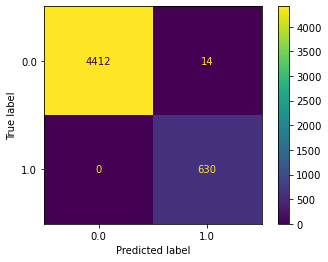

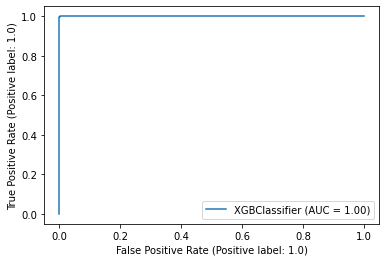

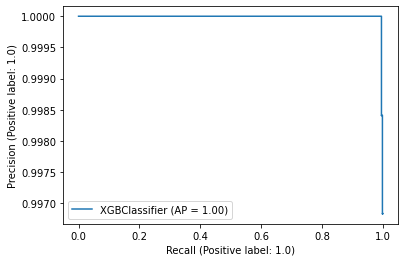

In [11]:
# Test the classifier on the training data
train_pred = clf.predict(nj_train_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
train_pred = np.where(clf.predict_proba(nj_train_features)[:,1] >= THRESHOLD, 1, 0)
train_pred = (clf.predict_proba(nj_train_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our training data and plot an ROC curve
print(classification_report(nj_train_target, train_pred))

cm = confusion_matrix(nj_train_target, train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, nj_train_features, nj_train_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, nj_train_features, nj_train_target)
plt.show()

              precision    recall  f1-score   support

       False       0.97      0.93      0.95       816
        True       0.54      0.72      0.62        93

    accuracy                           0.91       909
   macro avg       0.76      0.83      0.78       909
weighted avg       0.92      0.91      0.92       909



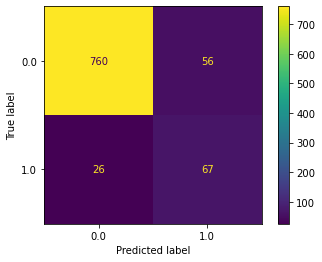

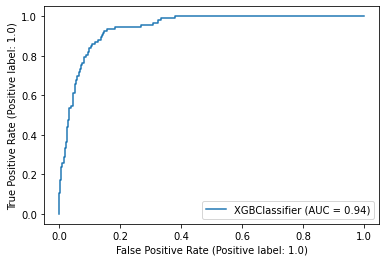

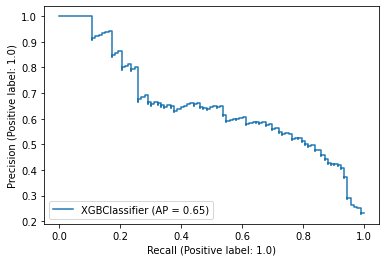

In [12]:
# Test the classifier on the test data
test_pred = clf.predict(nj_test_features)

## CHange the threshold
## https://towardsdatascience.com/classification-metrics-thresholds-explained-caff18ad2747
THRESHOLD = 0.25
test_pred = np.where(clf.predict_proba(nj_test_features)[:,1] >= THRESHOLD, 1, 0)
test_pred = (clf.predict_proba(nj_test_features)[:,1] >= THRESHOLD).astype(int)

# Print a report of the quality of the classifier on our test data and plot an ROC curve
print(classification_report(nj_test_target, test_pred))

cm = confusion_matrix(nj_test_target, test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot ROC curve
metrics.plot_roc_curve(clf, nj_test_features, nj_test_target) 
plt.show()

# Plot the precision recall curve
disp = plot_precision_recall_curve(clf, nj_test_features, nj_test_target)
plt.show()

## Neural Network

In [17]:
ejscreen_train2, ejscreen_val = train_test_split(ejscreen_train, test_size=0.2, random_state=42)

ejscreen_train2_features = ejscreen_train2.drop('target', axis = 1)
ejscreen_train2_target = ejscreen_train2['target']

ejscreen_val_features = ejscreen_val.drop('target', axis = 1)
ejscreen_val_target = ejscreen_val['target']

In [40]:
## Defines the Neural Network model
## three dense hidden layers with 32 nodes

inputs = keras.Input(shape=(11,))
x = layers.Dense(32, activation="sigmoid")(inputs)
x = layers.Dense(32, activation="sigmoid")(x)
x = layers.Dense(32, activation="sigmoid")(x)
outputs = layers.Dense(2, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [41]:
## Prepare the model with additional information about how to train it!  (i.e. "compile" it)
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer Adam
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [42]:
ejscreen_val_features.head()

,D_LDPNT_2,D_DSLPM_2,D_CANCR_2,D_RESP_2,D_PTRAF_2,D_PWDIS_2,D_PNPL_2,D_PRMP_2,D_PTSDF_2,D_OZONE_2,D_PM25_2
152986,15.817768,60.217856,14793.195272,181.100144,66821.482903,24.127715,67.332149,643.916286,1153.167437,10327.005889,2612.874556
163475,87.414278,88.103294,2786.602398,44.202135,104627.121401,0.692184,6.800924,180.474125,680.093160,3966.772690,816.689900
123158,-55.127328,-15.055149,-2313.901511,-28.924263,3071.111539,-939.309845,-1.035255,-4.366601,-3.677206,-4771.066948,-837.220294
131849,-97.792769,-151.198635,-4219.024809,-66.578676,-52550.514704,-5252.582338,-16.663439,-267.420187,-1604.238642,-4927.727652,-1075.649366
147007,-102.602153,-20.789616,-4015.981204,-43.320564,-7845.292736,-0.722249,-3.277436,-267.914507,-248.898389,-7539.717388,-1402.713524


In [46]:
## Fit our model with the initial training data, and check it with the "validation" training data!
print("Fit model on training data")
history = model.fit(
    ejscreen_train_features,
    ejscreen_train_target,
    batch_size=32,
    epochs=100,
    validation_data=(ejscreen_val_features, ejscreen_val_target),
)

Fit model on training data
Train on 176266 samples, validate on 35254 samples
Epoch 1/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4933 - acc: 0.7724 - val_loss: 0.4943 - val_acc: 0.7755
Epoch 2/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4934 - acc: 0.8082 - val_loss: 0.4931 - val_acc: 0.8300
Epoch 3/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4934 - acc: 0.7729 - val_loss: 0.4945 - val_acc: 0.7729
Epoch 4/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4935 - acc: 0.8030 - val_loss: 0.4940 - val_acc: 0.7585
Epoch 5/100
176266/176266 [==============================] - 5s 29us/sample - loss: 0.4935 - acc: 0.7546 - val_loss: 0.4939 - val_acc: 0.7708
Epoch 6/100
176266/176266 [==============================] - 5s 29us/sample - loss: 0.4938 - acc: 0.8126 - val_loss: 0.4946 - val_acc: 0.8374
Epoch 7/100
176266/176266 [==============================] - 5s 29us/s

Epoch 58/100
176266/176266 [==============================] - 5s 29us/sample - loss: 0.4928 - acc: 0.7997 - val_loss: 0.4936 - val_acc: 0.7608
Epoch 59/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4925 - acc: 0.8069 - val_loss: 0.4930 - val_acc: 0.7703
Epoch 60/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4923 - acc: 0.7752 - val_loss: 0.4924 - val_acc: 0.7713
Epoch 61/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4923 - acc: 0.7661 - val_loss: 0.4938 - val_acc: 0.7776
Epoch 62/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4920 - acc: 0.7596 - val_loss: 0.4930 - val_acc: 0.7914
Epoch 63/100
176266/176266 [==============================] - 5s 28us/sample - loss: 0.4921 - acc: 0.7818 - val_loss: 0.4931 - val_acc: 0.8107
Epoch 64/100
176266/176266 [==============================] - 5s 29us/sample - loss: 0.4922 - acc: 0.8101 - val_loss: 0.4929 - val_acc: 0.8878

In [ ]:
model.summary()

In [47]:

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(ejscreen_test_features, ejscreen_test_target, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
27664/27664 [==============================] - 0s 4us/sample - loss: 0.4907 - acc: 0.8140
test loss, test acc: [0.49074251748979125, 0.81398207]
